In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [26]:
products_path = 'data/amazon_products.csv'
categories_path = 'data/amazon_categories.csv'

products = pd.read_csv(products_path)
categories = pd.read_csv(categories_path)

In [27]:
merged_data = pd.merge(products, categories, left_on='category_id', right_on='id')

merged_data['DiscountRate'] = (merged_data['listPrice'] - merged_data['price']) / merged_data['listPrice']
merged_data['DiscountRate'] = merged_data['DiscountRate'].fillna(0).clip(lower=0)

merged_data = merged_data[['title', 'imgUrl', 'price', 'listPrice', 'DiscountRate', 'stars', 'reviews', 'boughtInLastMonth', 'category_name']]
merged_data.dropna(inplace=True)

encoder = LabelEncoder()
merged_data['category_encoded'] = encoder.fit_transform(merged_data['category_name'])

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(merged_data[['price', 'listPrice', 'DiscountRate', 'stars', 'reviews', 'boughtInLastMonth', 'category_encoded']])

In [ ]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 0]) 
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(scaled_features, window_size)

split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [29]:
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

C:\Users\salah\Desktop\EventRecommendationSystem\flask-api\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8915/8915 ━━━━━━━━━━━━━━━━━━━━ 332s 37ms/step - loss: 5.5180e-05 - val_loss: 2.0628e-05
Epoch 2/10
8915/8915 ━━━━━━━━━━━━━━━━━━━━ 308s 35ms/step - loss: 4.6634e-05 - val_loss: 2.0670e-05
Epoch 3/10
8915/8915 ━━━━━━━━━━━━━━━━━━━━ 307s 34ms/step - loss: 3.7877e-05 - val_loss: 2.1260e-05
Epoch 4/10
8915/8915 ━━━━━━━━━━━━━━━━━━━━ 309s 35ms/step - loss: 4.3119e-05 - val_loss: 2.1082e-05
Epoch 5/10
8915/8915 ━━━━━━━━━━━━━━━━━━━━ 311s 35ms/step - loss: 4.1858e-05 - val_loss: 2.0148e-05
Epoch 6/10
8915/8915 ━━━━━━━━━━━━━━━━━━━━ 311s 35ms/step - loss: 4.0161e-05 - val_loss: 2.0890e-05
Epoch 7/10
8915/8915 ━━━━━━━━━━━━━━━━━━━━ 324s 36ms/step - loss: 4.1780e-05 - val_loss: 2.0447e-05
Epoch 8/10
8915/8915 ━━━━━━━━━━━━━━━━━━━━ 316s 35ms/step - loss: 4.2798e-05 - val_loss: 2.0158e-05
Epoch 9/10
8915/8915 ━━━━━━━━━━━━━━━━━━━━ 319s 36ms/step - loss: 3.9768e-05 - val_loss: 2.0439e-05
Epoch 10/10
8915/8915 ━━━━━━━━━━━━━━━━━━━━ 318s 36ms/step - loss: 3.8971e-05 - val_loss: 2.0620e-05


In [37]:
os.makedirs('models', exist_ok=True)
model.save('predictions/black_friday/black_friday_model.h5')

In [31]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate([predictions, np.zeros((len(predictions), 6))], axis=1))[:, 0]

titles = merged_data['title'].values[-len(predictions):]
img_urls = merged_data['imgUrl'].values[-len(predictions):]
price_old = merged_data['listPrice'].values[-len(predictions):]
discount_rates = merged_data['DiscountRate'].values[-len(predictions):]

8915/8915 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step


In [38]:
result_df = pd.DataFrame({
    'Title': titles,
    'Image URL': img_urls,
    'Old Price': price_old,
    'Discount Rate': discount_rates,
    'Predicted Price': predictions
})

result_df['Effective Discount'] = result_df['Old Price'] - result_df['Predicted Price']
result_df = result_df.sort_values(by='Effective Discount', ascending=False).head(100)

os.makedirs('predictions', exist_ok=True)
result_df.to_csv('predictions/black_friday/black_friday_predictions.csv', index=False)

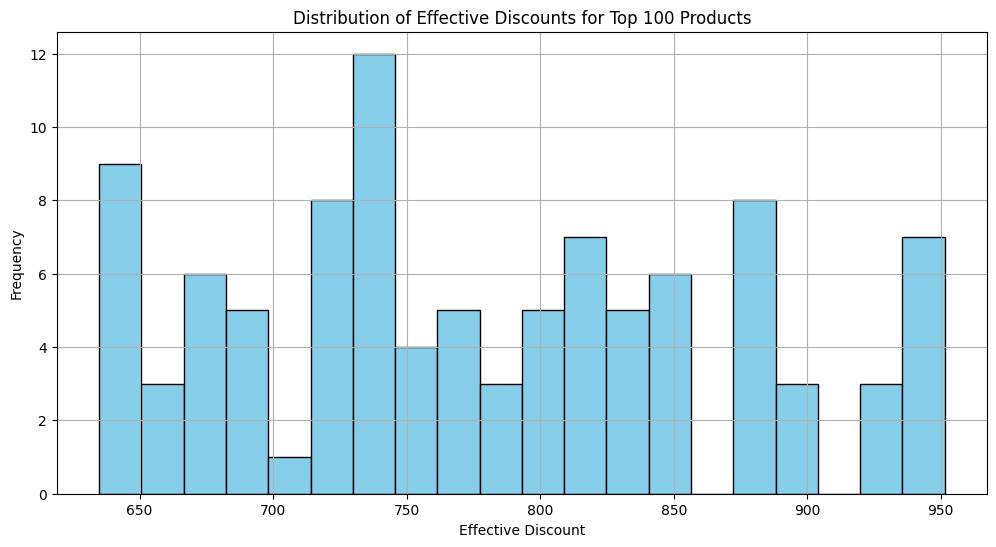

In [34]:
plt.figure(figsize=(12, 6))
plt.hist(result_df['Effective Discount'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Effective Discounts for Top 100 Products')
plt.xlabel('Effective Discount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

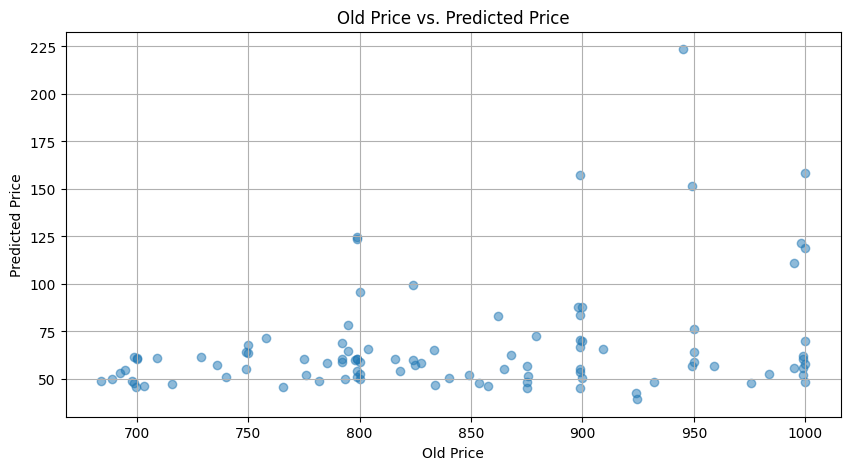

In [35]:
plt.figure(figsize=(10, 5))
plt.scatter(result_df['Old Price'], result_df['Predicted Price'], alpha=0.5)
plt.title('Old Price vs. Predicted Price')
plt.xlabel('Old Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()